# A simple Resnet based Classification using Focal Loss

#### References: Resnet: https://arxiv.org/abs/1512.03385, Focal loss: https://arxiv.org/pdf/1708.02002.pdf

### Step 1 : Download the natural images dataset from here : https://www.kaggle.com/prasunroy/natural-images
### Step 2 : Create mapping from object to numbers## Step 1: Create mapping from object to numbers

In [8]:
# map categories to integers
categories_to_number_map = {'airplane' : 0,
                           'car' : 1,
                           'cat' : 2,
                           'dog' : 3,
                           'flower' : 4,
                           'fruit' : 5,
                           'motorbike' : 6,
                           'person' : 7}

### Step 3: Write a DataLoader
#### DataLoader has two responsibilities
* Check for data balance per category
* Divide the data into train and test

In [9]:
import glob
import numpy as np
import random
class DataLoader:
    def __init__(self, path, categories, test_size=0.2, check_imbalance=True, seed=666):
        self.path = path
        self.categories = categories
        self.test_ratio = test_size
        self.check_imbalance = check_imbalance
        self.seed = seed
        
    def __get_no_of_files_per_category__(self):
        if not self.check_imbalance:
            return -1
        else:
            size_p_category = []
            for category in self.categories:
                files = glob.glob(self.path + category + '/*.jpg')
                assert(len(files) > 0)
                size_p_category.append(len(files))
            
            return min(size_p_category)
        
    # split the data in train and test set
    def get_data(self):   
        n_files = self.__get_no_of_files_per_category__()
        train_dict, test_dict = {}, {}
        for category in self.categories:
            print('processing category {}'.format(category))
            files = glob.glob(self.path + category + '/*.jpg')
            random.seed(self.seed)
            random.shuffle(files)
            if n_files > 0:
                files = files[:n_files]
                train_size = int(n_files * (1 - self.test_ratio))
                #test_size = int(n_files * self.test_ratio)
            else:
                n_all_files = len(files)
                train_size = int(n_all_files * (1 - self.test_ratio))
                #test_size = int(n_files * self.test_ratio)
            assert(train_size<len(files))
            train_dict[category] = files[:train_size].copy()
            test_dict[category] = files[train_size+1:].copy()
            
        return train_dict, test_dict
            
            

### Step 4 : Define a DataGenerator 
#### The DataGenerator is responsible for the followings-
* Help to train neural network in batches
* Do data augmentation
* Provide input data in one hot encoding format

In [10]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
class DataGenerator(Sequence):
    def __init__(self, batch_size, shape, X_dict, categories_to_number_map, aug={}, aug_p_img=1, seed=666):
        self.batch_size = batch_size
        self.shape = shape
        self.x_dict = X_dict
        self.categories_to_number_map = categories_to_number_map
        self.seed = seed
        self.augmenter_x = ImageDataGenerator(**aug)
        self.aug_p_img = aug_p_img
        # create placeholders for the images and labels
        self.__images_batch__ = np.empty((batch_size*aug_p_img, shape[0], shape[1], shape[2]), dtype=np.float32)
        self.__labels_batch__ = np.empty((batch_size*aug_p_img, len(categories_to_number_map)), dtype=np.float32)
        
        self.x_data, self.y_data = self.__load_data__()
        # print(len(self.x_data))
        self.indexes = np.arange(len(self.x_data))
        
    def __load_data__(self):
        x, y = [],[]
        for key in self.categories_to_number_map.keys():
            #print(key)
            x.extend(self.x_dict[key])
            labels = list(np.ones(len(self.x_dict[key])) * self.categories_to_number_map[key])
            y.extend(labels) 
        
        random.seed(self.seed)
        random.shuffle(x)
        random.seed(self.seed)
        random.shuffle(y)
        #print(x)
        #print(y)
        return np.array(x),np.array(y)
    
    def __get_one_hot_encoding__(self, indexes):
        y_labels = self.y_data[indexes]
        size = len(self.categories_to_number_map)
        for i, label in enumerate(y_labels):
            one_hot_encoded = np.zeros(size).astype(np.float32)
            one_hot_encoded[int(label)] = 1.0
            for j in range(self.aug_p_img):
                self.__labels_batch__[i*self.aug_p_img + j] = one_hot_encoded.copy()
            
        
    def __populate_batches__(self, indexes):
        x_files = self.x_data[indexes]
        
        for i, file in enumerate(x_files):
            #print(file)
            img = cv2.imread(file)
            img = cv2.resize(img, (self.shape[0], self.shape[1]))
            img = np.expand_dims(img, axis=0)
            image_iterator = self.augmenter_x.flow(img, batch_size=self.aug_p_img, seed=self.seed)
            for j in range(self.aug_p_img):
                image_x = image_iterator.next()[0].copy()
                self.__images_batch__[i*self.aug_p_img + j] = image_x / 255.
        
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        self.__populate_batches__(indexes)
        self.__get_one_hot_encoding__(indexes)
        
        return self.__images_batch__, self.__labels_batch__
    
    def __len__(self):
        return len(self.indexes)
    

### Step 5: Create a model
### ModelProvider has the following responsibilities
* Create a Resnet based model 
* Create call backs for saving the model and monitor validation loss

In [11]:
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Dense, Dropout, Add, Flatten
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.metrics import jaccard_score
class ModelProvider:
    def __init__(self, shape, loss, optimiser, check_point, n_classes ):
        self.loss = loss()
        self.optimiser = optimiser
        self.n_classes = n_classes
        self.check_point = check_point
        self.shape = shape
        
    def create_callbacks(self):
        from tensorflow.keras.callbacks import ModelCheckpoint, Callback
        checkpoint_file = str(self.check_point) 
        checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss',
                                     save_best_only=True)
        print('callbacks created.')

        return [checkpoint]
    
    def __identity_block__(self, x, n_filters, strides=1, kernel_size=(3,3), upscale=False):
        x_prev = x
        
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same') (x)
        x = BatchNormalization()(x)
        x = Activation(relu)(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same') (x)
        x = BatchNormalization()(x)
        x = Activation(relu)(x)  
        if upscale:
            x_prev = Conv2D(kernel_size=1, filters=n_filters, strides=1, padding='same')(x)
        x = Add()([x, x_prev])
        x = Activation(relu)(x)
        
        return x
    
    def iou_score(self,y_true, y_pred):
        return tf.keras.metrics.MeanIoU(num_classes=self.n_classes, name='iou_score')
        
    def create_model(self):
                           
        input_tensor = Input(self.shape)
        x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same')(input_tensor)
        x = self.__identity_block__(x, 16)
        x = MaxPooling2D((2,2))(x)
        x = self.__identity_block__(x, 16)
        x = MaxPooling2D((2,2))(x)
        x = self.__identity_block__(x, 16)
        x = MaxPooling2D((2,2))(x)
        x = self.__identity_block__(x, 16)
        x = Flatten()(x)
        x = Dense(100)(x)
        x = BatchNormalization()(x)
        x = Activation(relu)(x)
        x = Dropout(0.5)(x)
        x = Dense(self.n_classes)(x)
        x = Activation(softmax)(x)
    
        model = Model(inputs=input_tensor, outputs=x)
        model.compile(loss=self.loss, optimizer=self.optimiser, metrics=['accuracy'])
        # model.summary()
        print('model created')
        return model
    

### Step 6: Define binary focal loss

In [12]:
def binary_focal_loss(gamma=2., alpha=.25):
        from tensorflow.keras import backend as K
        """
        Binary form of focal loss.
          FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
          where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
        References:
            https://arxiv.org/pdf/1708.02002.pdf
        Usage:
         model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
        """
        def binary_focal_loss_fixed(y_true, y_pred):
            """
            :param y_true: A tensor of the same shape as `y_pred`
            :param y_pred:  A tensor resulting from a sigmoid
            :return: Output tensor.
            """
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

            epsilon = K.epsilon()
            # clip to prevent NaN's and Inf's
            pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
            pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

            return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                   -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

        return binary_focal_loss_fixed


### Step 7:  Additional gaussian noise has been added to the images which is not present in Keras ImageDataGenerator and 
### Step 8 : Prepare the modules for training

In [13]:
import random
random.seed(666)
def add_preprocessing(img):
    # adding gaussian blur for 30% of the images
    def add_gaussian_blur(img):
        if( random.random() < 0.3):
            return cv2.GaussianBlur(img,(5,5),0)
        return img
    
    img = add_gaussian_blur(img)
    return img
# train the model
shape = (256, 256, 3)
categories_to_number_map = {'airplane' : 0,
                           'car' : 1,
                           'cat' : 2,
                           'dog' : 3,
                           'flower' : 4,
                           'fruit' : 5,
                           'motorbike' : 6,
                           'person' : 7}
path = 'natural_images/'
aug_x = dict(#rotation_range=90,
            brightness_range=(0.7,1.5),
            horizontal_flip=True,
            vertical_flip=True,
            preprocessing_function=add_preprocessing)
data_loader = DataLoader(path, categories_to_number_map.keys(), check_imbalance=True)
x_train, x_test = data_loader.get_data()
train_data_gen = DataGenerator(8, shape, x_train, categories_to_number_map, aug=aug_x, aug_p_img=2,)
test_data_gen = DataGenerator(8, shape, x_test, categories_to_number_map)

processing category airplane
processing category car
processing category cat
processing category dog
processing category flower
processing category fruit
processing category motorbike
processing category person


### Step 9: Starting training
* Using adam as optimizer with learning_rate as 0.001
* Loss function as categorical_crossentropy

In [14]:
checkpoint = 'class.h5'
import tensorflow as tf
optimiser = tf.keras.optimizers.Adam(lr=0.001)
model_provider = ModelProvider(shape, binary_focal_loss, optimiser, checkpoint, len(categories_to_number_map))
model = model_provider.create_model()
callback_list = model_provider.create_callbacks()
epochs = 5
model.summary()
history = model.fit_generator(generator=train_data_gen,
                    validation_data=test_data_gen,
                    epochs=epochs,
                    workers=8,
                    use_multiprocessing=True,
                    callbacks=callback_list)

model created
callbacks created.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_9[0][0]                   
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 256, 256, 16) 64          conv2d_10[0][0]                  
____________________________________________________________________________

### Step 10: Plot the Validation loss vs Training loss

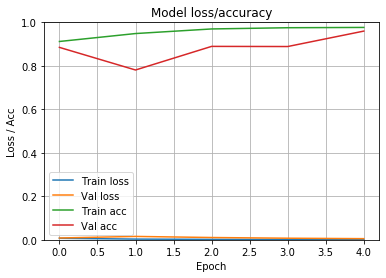

In [16]:
import matplotlib.pyplot as plt
# Plot training vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim([0, 1])
plt.title('Model loss/accuracy')
plt.ylabel('Loss / Acc')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss', 'Train acc', 'Val acc'])
plt.grid()

### Step 11: Check some output from test cases
* Load the best model saved


In [17]:
model.load_weights('class.h5')

In [28]:
x, y_gt = test_data_gen[9]
y_pred = model.predict(x)

In [29]:
np.argmax(y_gt, axis=1)

array([7, 3, 6, 5, 2, 6, 7, 1])

In [30]:
np.argmax(y_pred, axis=1)

array([7, 3, 6, 5, 2, 6, 7, 1])

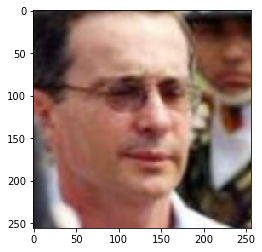

In [23]:
plt.imshow(cv2.cvtColor(x[0], cv2.COLOR_BGR2RGB))

In [ ]:
### Step 12: Check the average accuracy 

In [24]:
metrics = ['accuracy', 'iou_score']
scores = model.evaluate_generator(test_data_gen)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("Average {}: {:.5}".format(metric, value))

Loss: 0.0013483
Average accuracy: 0.98717
